In [1]:
import pandas as pd; pd.options.display.float_format = '{:,.2f}'.format
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_style("dark")
from IPython.display import display

## Cleaning and data prep

In [2]:
def merge_columns(df, columns):
    return (
        df[columns]
        .stack()
        .reset_index()
        .set_index('level_0')
        .where(lambda df: df[0] != 0)
        .dropna()
        .drop(0, axis=1)
    )

data2014 = pd.read_csv('data/data2014.csv').assign(year=2014)
data2015 = pd.read_csv('data/data2015.csv').assign(year=2015)
data = pd.concat([data2014, data2015], axis=0).reset_index(drop=True)

data = (
    data
    .assign(
        provider=merge_columns(data, ['Bank', 'Dealer', 'Volunteer', 'Liquidator']),
        day_period=merge_columns(data, ['Morning', 'Afternoon', 'Evening']),
    )
    
)

cols = ["multiplier", "EstValue", "StartPrice", "SP.EV", "Followers"]
log10 = pd.DataFrame(np.log10(data[cols].values), columns=list(map("l{}".format, cols)))
data = pd.concat([data, log10], axis=1)
data.sample(5)

,multiplier,LotNr,Allocate,EstValue,StartPrice,Followers,Bank,Dealer,Liquidator,Volunteer,...,Evening,Afternoon,year,provider,day_period,lmultiplier,lEstValue,lStartPrice,lSP.EV,lFollowers
4725,0.68,216,0,25,15,13,0,1,0,0,...,0,1,2014,Dealer,Afternoon,-0.17,1.40,1.18,-0.22,1.11
6116,2.00,1165,0,35,25,14,0,1,0,0,...,0,1,2014,Dealer,Afternoon,0.30,1.54,1.40,-0.15,1.15
10277,1.17,642,0,60,50,23,0,1,0,0,...,0,1,2015,Dealer,Afternoon,0.07,1.78,1.70,-0.08,1.36
4553,1.12,24,0,40,20,24,0,1,0,0,...,0,1,2014,Dealer,Afternoon,0.05,1.60,1.30,-0.30,1.38
9633,1.87,1325,0,75,50,24,0,1,0,0,...,0,1,2015,Dealer,Afternoon,0.27,1.88,1.70,-0.18,1.38


### Multiplier of the Estimated Value

The value to optimise is the ratio between the sale price and the estimated value. The distribution is highly skewed. 98% of the values are between 0 and 5. In contrast, the whole sample range between 0 and 57. Extreme values hare observed more than 1% of the time.

year,2014,2015
count,"6,901.00","4,415.00"
mean,1.15,1.34
std,1.03,2.02
min,0.01,0.06
25%,0.67,0.73
50%,0.80,0.93
75%,1.29,1.40
max,19.50,57.00


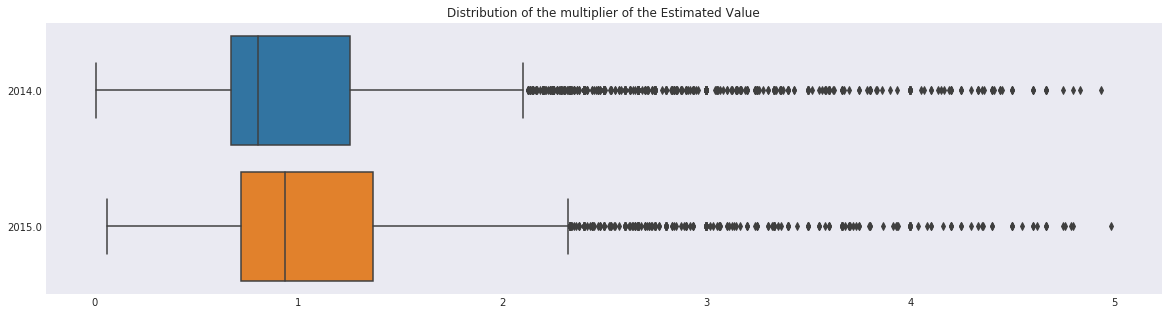

In [3]:
def empty_axes(figsize):
    fig = plt.figure(figsize=figsize)
    return fig.add_subplot(111)

ax = sns.boxplot(
    x="multiplier", 
    y="year", 
    orient="h", 
    data=data.where(data["multiplier"] < 5).dropna(), 
    ax=empty_axes((20,5))
)

display(pd.DataFrame(data.pivot(columns="year", values="multiplier").describe()))
ax.set_xlabel(""); ax.set_ylabel(""); ax.set_title("Distribution of the multiplier of the Estimated Value");

Taking the logarithm of price related values makes the visualisation of the data more human-readable. The logarithmic tranformation often gives good results on proportions because they cannot be negative and thus have limited degrees of freedom.<br/>
In our new log-multiplier space, positive values denote a sales price higher than the estimated value and negative values denote a loss on the lot sale.

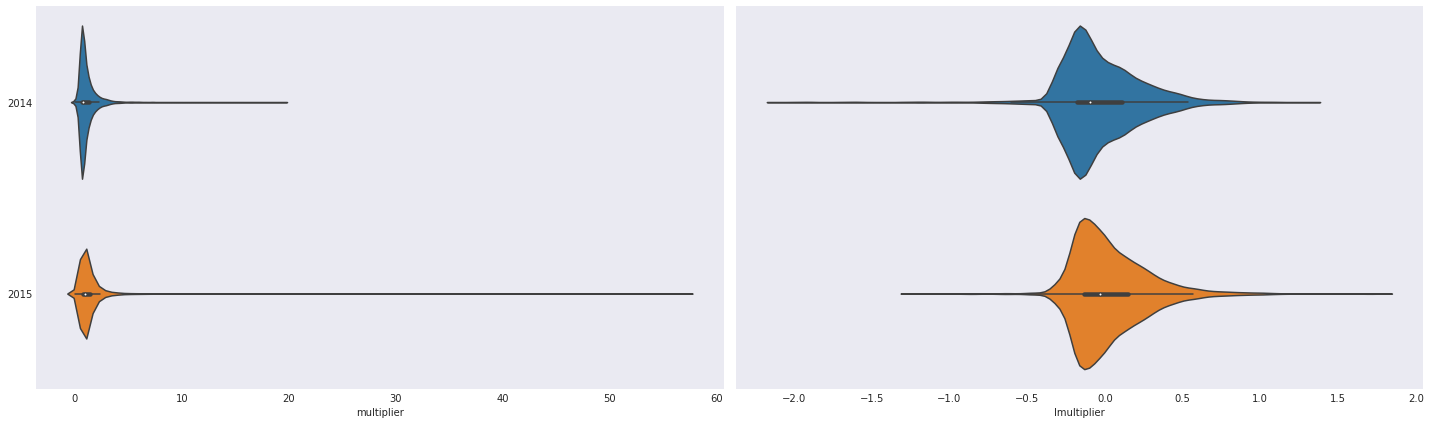

In [4]:
fig, axs = plt.subplots(1, 2, figsize=(20, 6), sharey=True)
for name, ax in zip(["multiplier", "lmultiplier"], axs):
    sns.violinplot(x=name, y="year", orient='h', data=data, ax=ax)
    ax.set_ylabel("")
plt.tight_layout()

## Correlation matrix

**TODO: define the task and study relevant features (i.e. the features that we can modify)**<br/>
The number of followers is the feature with the highest correlation coefficient with the target variable. As expected, the start price is highly correlated with the estimated value. However, neither these values nor their ratio are very much correlated with the multiplier. The correlation is a little better for logarithmic values. Interestingly, the number of followers appear to be positively correlated with both the start price and estimated value but is negatively correlated with the ratio of these values.<br/>
Another element worth noting is the negative correlation between the multiplier and both the lot number and the dealer indicator.

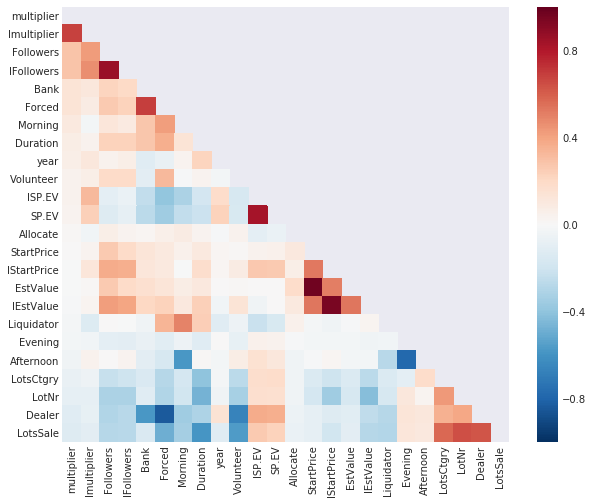

In [5]:
selected_columns = [
    'multiplier', 'lmultiplier', 
    'SP.EV', 'lSP.EV', 
    'EstValue', 'lEstValue', 
    'StartPrice', 'lStartPrice', 
    'Followers', 'lFollowers', 
    'LotNr', 'LotsSale', 'LotsCtgry', 
    'Duration', 'Allocate', 'Forced', 'year',
    'Bank', 'Dealer', 'Liquidator', 'Volunteer', 
    'Morning', 'Evening', 'Afternoon', 
]
corr = data[selected_columns].corr().sort_values("multiplier", ascending=False)
corr = corr[corr.index]
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, cmap="RdBu_r", vmax=1, vmin=-1, ax=empty_axes((10,8)), mask=mask)
fig.suptitle('How are the variables correlated?', size= 14);

### Multiplier, Start Price and Estimated Value

The figure below shows a log-log regression plot of SP/EV and the multiplier. The red lines divide the plotting area into four parts. The examples right to the vertical line were auctioned with a start price higher than their estimated price. The examples below the horizontal line are those that were sold for a lower price than their estimated value. We have also displayed the baseline in grey, which represent the lowest multiplier that a lot can be expected to have for a given start price.<br/>
Not surprisingly, very few items were sold with a start price higher than their estimated value. None of the sample have very high multiplier either.<br/>
Although a clear relation cannot be observed, we see that below a certain threshold (a start price below 3% of the estimated value), a lot is never giving a positive return. The best multipliers are observed for start prices relatively close to the estimated value (starting at 30% of its estimated value).

In [16]:
X_train.columns

Index(['multiplier', 'LotNr', 'Allocate', 'EstValue', 'StartPrice',
       'Followers', 'Bank', 'Dealer', 'Liquidator', 'Volunteer', 'LotsSale',
       'LotsCtgry', 'Forced', 'SP.EV', 'Duration', 'Morning', 'Evening',
       'Afternoon', 'year', 'provider', 'day_period', 'lEstValue',
       'lStartPrice', 'lSP.EV', 'lFollowers'],
      dtype='object')

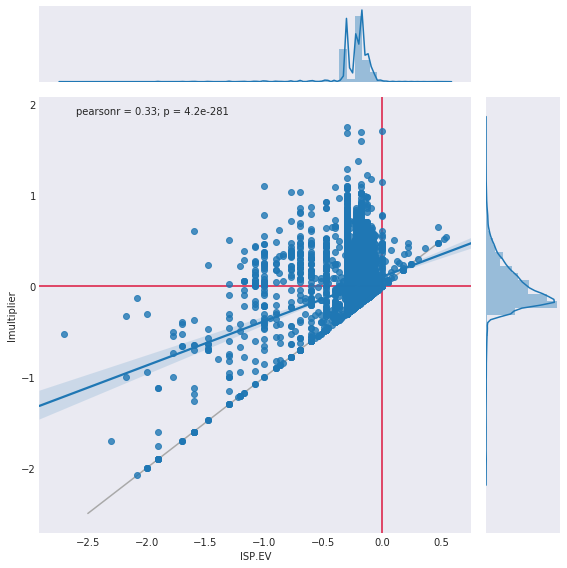

In [6]:
g = sns.jointplot(x="lSP.EV", y="lmultiplier", data=data, kind='reg', size=8)
x = np.linspace(-2.5, .5, 100); g.ax_joint.plot(x, x, c='darkgrey', zorder=0)
g.ax_joint.axhline(y=0, c='crimson', zorder=0); g.ax_joint.axvline(x=0, c='crimson', zorder=0);

### Period of the day and Multiplier

Most of the lots were sold in the afternoon. 

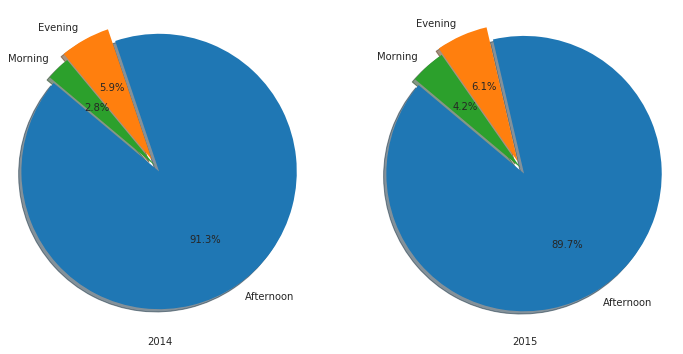

In [7]:
# colors = ['gold', 'yellowgreen', 'lightcoral']
explode = (.05, .05, .0)
axs = (data
 .groupby(["year", "day_period"])["multiplier"]
 .count()
 .unstack(level=0)
 .plot(kind='pie', explode=explode, autopct='%1.1f%%', shadow=True, startangle=140, subplots=True)
)

for ax in axs:
    ax.set_xlabel(ax.get_ylabel())
    ax.set_ylabel("")
    ax.get_legend().set_visible(False)
    ax.axis('equal')
    
plt.gcf().set_size_inches((12,6))

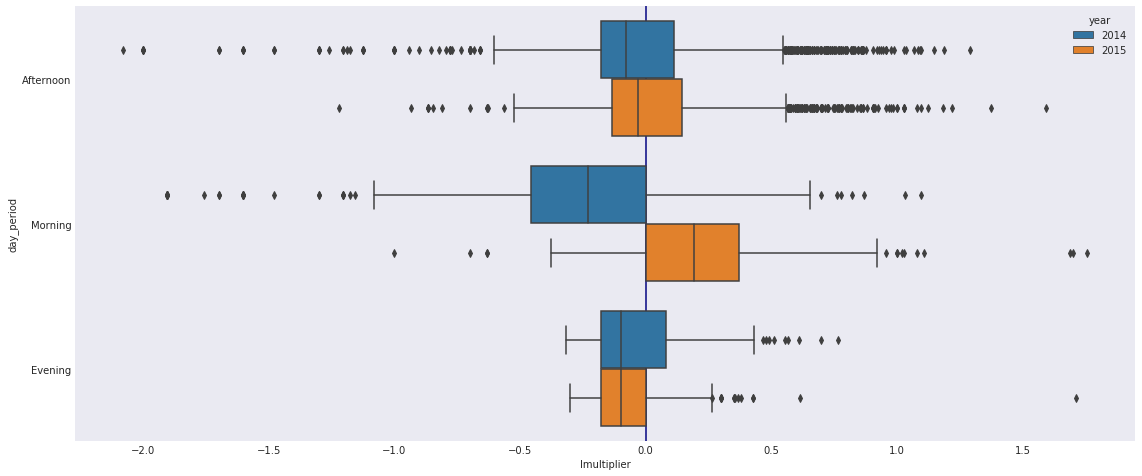

In [8]:
ax = sns.boxplot(x="lmultiplier", y="day_period", hue="year", orient='h', data=data.sort_values("provider"), ax=empty_axes((19,8)))
ax.axvline(x=0, color="navy", zorder=0);

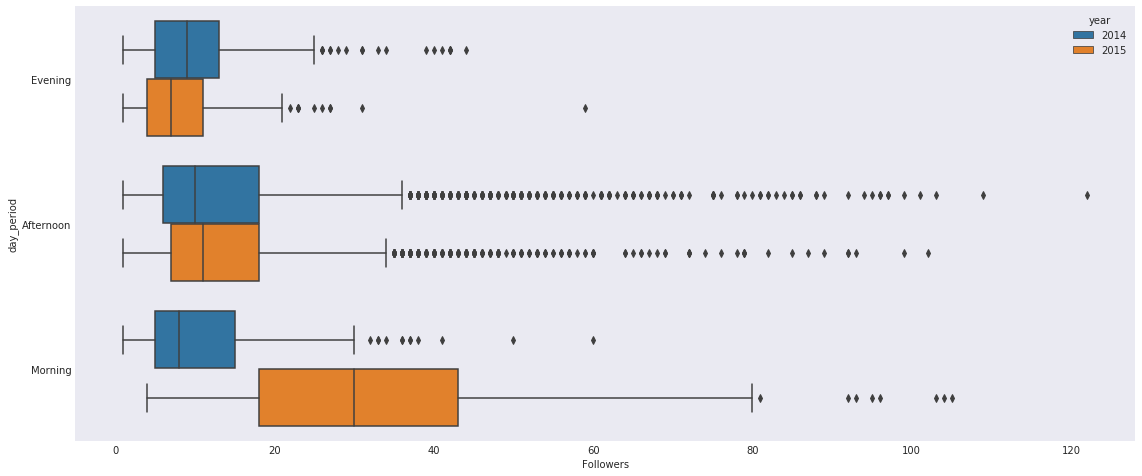

In [9]:
sns.boxplot(x="Followers", y="day_period", hue="year", orient='h', data=data, ax=empty_axes((19,8)));

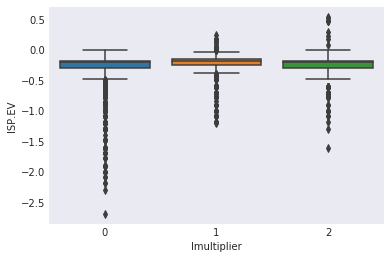

In [10]:
from sklearn.model_selection import train_test_split

X, y = data.drop("lmultiplier", axis=1), data["lmultiplier"]
X_train, X_test, y_train, y_test = train_test_split(X, y)

bins = np.array([-2., 0., .3, 2])

def cut(X, filter_values, log=False):
    if log: X = np.log2(X)
    X_cut = pd.cut(X, bins=filter_values)
    X_cut = X_cut.map(lambda x: np.argmax(filter_values > x.left) - 1)
    X_cut.loc[X_cut.isnull()] = X[X_cut.isnull()].map(lambda x: len(filter_values) - 2 if x > filter_values[-1] else 0)
    return X_cut

y_train_bins = cut(y_train, bins, log=False)
y_test_bins = cut(y_test, bins)

sns.boxplot(x=y_train_bins, y=X_train["lSP.EV"]);

## Different auctions methods

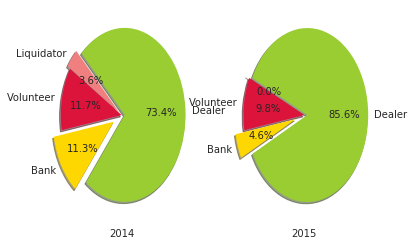

In [11]:
colors = ['gold', 'yellowgreen', 'lightcoral', 'crimson']
explode = (.15, .05, .05, .0)
# ax = empty_axes((16, 8))
axs = (data
 .groupby(["year", "provider"])["multiplier"]
 .count()
 .unstack(level=0)
 .plot(kind='pie', colors=colors, explode=explode, autopct='%1.1f%%', shadow=True, startangle=190, subplots=True)
)

for ax in axs:
    ax.set_xlabel(ax.get_ylabel())
    ax.set_ylabel("")
    ax.get_legend().set_visible(False)
    

In [12]:
data_2 = data[data['FinalPrice'] < 400]
display(data_2[['Dealer','Volunteer','Bank']].describe())
sns.violinplot(x="AuctionMethod", y="FinalPrice", data=data_2)

KeyError: 'FinalPrice'

In [ ]:
data_3 = data[data['StartPrice'] < 400]
print(data_3[['Dealer','Volunteer','Bank']].describe())
sns.violinplot(x="AuctionMethod", y="StartPrice", data=data_3)

In [ ]:
data_4 = data[data['multiplier'] < 4]
print(data_4[['Dealer','Volunteer','Bank']].describe())
sns.violinplot(x="AuctionMethod", y="multiplier", data=data_4)

In [ ]:
finals_per_auction = []
for x in auctionmethods:
    finals_per_auction.append(data_2['FinalPrice'].loc[data_2['AuctionMethod']==x].values)
plt.boxplot(finals_per_auction)
plt.title('Boxplots for final price per auction')
plt.xticks([1,2,3],auctionmethods)
plt.xlabel('Auction methods')
plt.ylabel('Final price')

In [ ]:
starting_per_auction = []
for x in auctionmethods:
    starting_per_auction.append(data_3['StartPrice'].loc[data_3['AuctionMethod']==x].values)
plt.boxplot(starting_per_auction)
plt.title('Boxplots for starting price per auction')
plt.xticks([1,2,3],auctionmethods)
plt.xlabel('Auction methods')
plt.ylabel('Starting price')

In [ ]:
multiplier_per_auction = []
for x in auctionmethods:
    multiplier_per_auction.append(data_4['multiplier'].loc[data_4['AuctionMethod']==x].values)
plt.boxplot(multiplier_per_auction)
plt.title('Boxplots for multiplier per auction')
plt.xticks([1,2,3],auctionmethods)
plt.xlabel('Auction methods')
plt.ylabel('Multiplier')

## Estimated and start value

In [ ]:
sns.jointplot(x="EstValue", y="StartPrice", data=data).plot_joint(sns.kdeplot)
data[["EstValue", "StartPrice"]].describe()

## Followers, duration

In [ ]:
print(data[['Dealer','Volunteer','Bank']].describe())
sns.violinplot(x="AuctionMethod", y="Followers", data=data)

In [ ]:
duration_per_auction = []
for x in auctionmethods:
    duration_per_auction.append(data['Duration'].loc[data['AuctionMethod']==x].values)
plt.boxplot(duration_per_auction)
plt.title('Boxplots for duration per auction')
plt.xticks([1,2,3],auctionmethods)
plt.xlabel('Auction methods')
plt.ylabel('Duration')

In [ ]:
sns.jointplot(x="Duration", y="FinalPrice", data=data).plot_joint(sns.kdeplot)
data[["Duration", "FinalPrice"]].describe()

In [ ]:
finals_per_dayperiod = []
for x in dayperiods:
    finals_per_dayperiod.append(data_2['FinalPrice'].loc[data_2['DayPeriod']==x].values)
plt.boxplot(finals_per_dayperiod)
plt.title('Boxplots for final price per day period')
plt.xticks([1,2,3],dayperiods)
plt.xlabel('Day periods')
plt.ylabel('Final price')